In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import pyerrors as pe

## Primary observables

We can load data from preprocessed pickle files which contain a list of `pyerror` `Obs`:

In [2]:
p_obs_names = ['f_A', 'f_P']

p_obs = {}
for i, item in enumerate(p_obs_names):
    p_obs[item] = pe.load_object('./data/B1k2_' + item + '.p')    

We can now use the `pyerrors` function `plot_corrs` to have a quick look at the data we just read in 

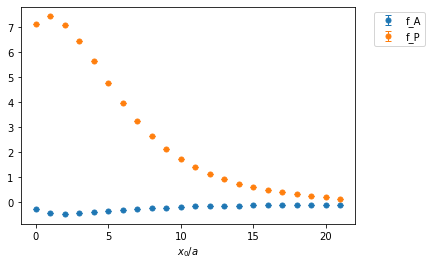

In [3]:
pe.plot_corrs([p_obs['f_A'], p_obs['f_P']], label=p_obs_names)

## Secondary observables

One way of generating secondary observables is to write the desired math operations as for standard floats. `pyerrors` currently supports the basic arithmetic operations as well as numpy's basic trigonometric functions.

We start by looking at the unimproved pcac mass $am=\tilde{\partial}_0 f_\mathrm{A}/2 f_\mathrm{P}$

In [4]:
uimpr_mass = []
for i in range(1, len(p_obs['f_A']) - 1):
    uimpr_mass.append((p_obs['f_A'][i + 1] - p_obs['f_A'][i - 1]) / 2 / (2 * p_obs['f_P'][i]))

For more complicated secondary obsevables or secondary observables we use over and over again it is often useful to define a dedicated function for it. Here is an example for the improved pcac mass

In [5]:
def pcac_mass(data, ca=0, **kwargs):
    return ((data[1] - data[0]) / 2. + ca * (data[2] - 2 * data[3] + data[4])) / 2. / data[3]

Now we can construct the derived observable `pcac_mass` from the primary ones. Note the additional argument `ca` with which we can provide a value for the $\mathrm{O}(a)$ improvement coefficient of the axial vector current.

In [6]:
impr_mass = []
for i in range(1, len(p_obs['f_A']) - 1):
    impr_mass.append(pcac_mass([p_obs['f_A'][i - 1], p_obs['f_A'][i + 1], p_obs['f_P'][i - 1],
                             p_obs['f_P'][i], p_obs['f_P'][i + 1]], ca=-0.03888694628624465))

To calculate the error of an observable we use the `gamma_method`. Let us have a look at the docstring

In [7]:
?pe.Obs.gamma_method

We can apply the `gamma_method` to the pcac mass on every time slice for both the unimproved and the improved mass.

In [8]:
masses = [uimpr_mass, impr_mass]
for i, item in enumerate(masses):
    [o.gamma_method() for o in item]

We can now have a look at the result by plotting the two lists of `Obs`

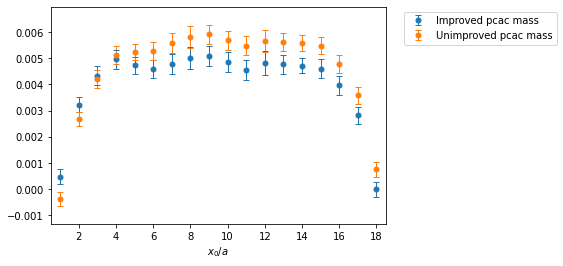

In [9]:
pe.plot_corrs([impr_mass, uimpr_mass], xrange=[0.5, 18.5], label=['Improved pcac mass', 'Unimproved pcac mass'])

## Tertiary observables

We can now construct a plateau as (tertiary) derived observable from the masses. At this point the distinction between primary and secondary observables becomes blurred. We can again and again resample objects into new observables which allows us to modulize the analysis. Note that `np.mean` and similar functions can be applied to the `Obs` as if they were real numbers.

In [10]:
pcac_plateau = np.mean(impr_mass[6:15])
pcac_plateau.gamma_method()
pcac_plateau.print()

Result	 4.79208242e-03 +/- 2.09091228e-04 +/- 1.90500140e-05 (4.363%)
  t_int	 1.09826949e+00 +/- 1.84087104e-01 S = 2.00


We can also use a weighted average with given `plateau_range` (passed to the function as kwarg)

In [11]:
def weighted_plateau(data, **kwargs):
    if 'plateau_range' in kwargs:
        plateau_range = kwargs.get('plateau_range')
    else:
        raise Exception('No range given.')
    
    num = 0
    den = 0
    for i in range(plateau_range[0], plateau_range[1]):
        if data[i].dvalue == 0.0:
            raise Exception('Run gamma_method for input first')
        num += 1 / data[i].dvalue * data[i]
        den += 1 / data[i].dvalue
    return num / den

In [12]:
w_pcac_plateau = weighted_plateau(impr_mass, plateau_range=[6, 15])
w_pcac_plateau.gamma_method()
w_pcac_plateau.print()

Result	 4.78698515e-03 +/- 2.04149923e-04 +/- 1.85998184e-05 (4.265%)
  t_int	 1.06605715e+00 +/- 1.79069383e-01 S = 2.00


In this case the two variants of the plateau are almost identical

We can now plot the data with the two plateaus

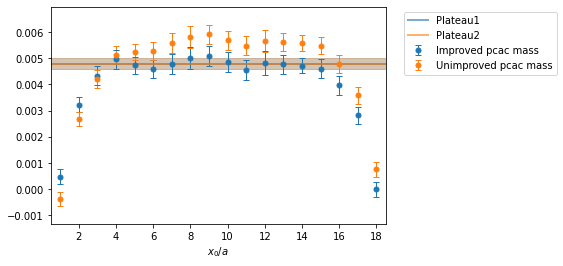

In [13]:
pe.plot_corrs([impr_mass, uimpr_mass], plateau=[pcac_plateau, w_pcac_plateau], xrange=[0.5, 18.5],
              label=['Improved pcac mass', 'Unimproved pcac mass'])

## Refined error analysis

There are two way of adjusting the value of S. One can either change the class variable `Obs.S_global`. The set value is then used for all following applications of the `gamma_method`.

In [14]:
pe.Obs.S_global = 3.0
pcac_plateau.gamma_method()
pcac_plateau.print()

Result	 4.79208242e-03 +/- 2.02509166e-04 +/- 2.05063968e-05 (4.226%)
  t_int	 1.03021214e+00 +/- 1.94552148e-01 S = 3.00


Alternatively one can call the gamma_method with the keyword argument S. This value overwrites the global value only for the current application of the `gamma_method`.

In [15]:
pcac_plateau.gamma_method(S=2.5)
pcac_plateau.print()

Result	 4.79208242e-03 +/- 2.04669865e-04 +/- 1.97135904e-05 (4.271%)
  t_int	 1.05231340e+00 +/- 1.88061498e-01 S = 2.50


We can have a look at the respective normalized autocorrelation function (rho) and the integrated autocorrelation time

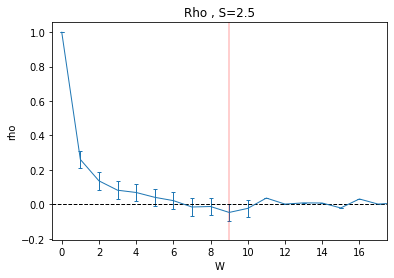

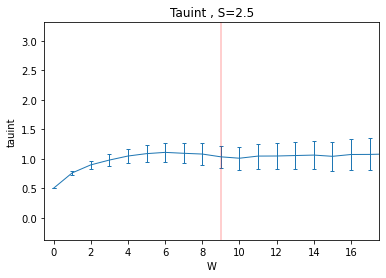

In [16]:
pcac_plateau.plot_rho()
pcac_plateau.plot_tauint()

## Critical slowing down

`pyerrors` also supports the critical slowing down analysis of arXiv:1009.5228

In [17]:
pcac_plateau.gamma_method(tau_exp=10, N_sigma=1)
pcac_plateau.print()

Result	 4.79208242e-03 +/- 2.28649024e-04 +/- 1.67571716e-05 (4.771%)
  t_int	 1.31333644e+00 +/- 5.19554793e-01 tau_exp = 10.00,  N_sigma = 1


The attached tail, which takes into account long range autocorrelations, is shown in the plots for rho and tauint

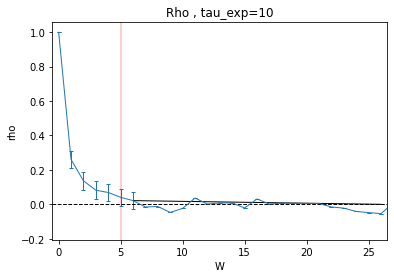

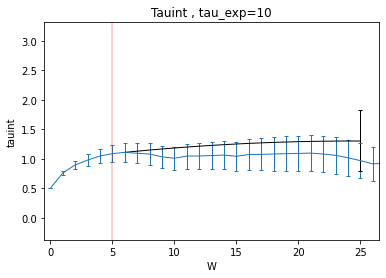

In [18]:
pcac_plateau.plot_rho()
pcac_plateau.plot_tauint()

Additional information on the ensembles and replicas can be printed with print level 2 (In this case there is only one ensemble with one replicum.)

In [19]:
pcac_plateau.print(2)

Result	 4.79208242e-03 +/- 2.28649024e-04 +/- 1.67571716e-05 (4.771%)
  t_int	 1.31333644e+00 +/- 5.19554793e-01 tau_exp = 10.00,  N_sigma = 1
1024 samples in 1 ensembles:
 : ['B1k2r2']


The Monte Carlo history of the observable can be accessed with `plot_history` to identify possible outliers or have a look at the shape of the distribution

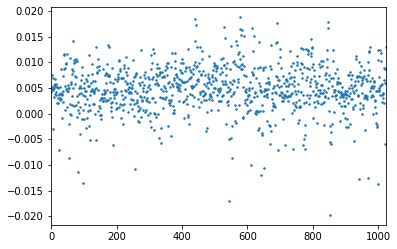

In [20]:
pcac_plateau.plot_history()

If everything is satisfactory, dump the `Obs` in a pickle file for future use. The `Obs` `pcac_plateau` conatains all relevant information for any follow up analyses.

In [21]:
pcac_plateau.dump('B1k2_pcac_plateau')